# Sudoku Solver (v3)
---

Close to final form.

Objectives:

1. Assess effectiveness and performance against different test cases
 1. Back tracking
 2. Back tracking + constraint propogation
 3. Deductive logic
 4. ~~Solution X or Dancing Links?~~
 5. Boolean Satisfiability (SAT) solver
3. Learn some more Pandas + Matplotlib (draw some pretty graphs)
4. ~~Assess performance against other implementations~~


## Supporting Packages

**TODO**: Brief description of [sudoku](sudoku.py) and [puzzlegrid](puzzlegrid.py) libraries.


In [1]:
import sudoku as su
import puzzlegrid as pg

**TODO**: Brief description of why we need the following

In [2]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 6]
pd.set_option('precision', 3)

## Help functions

**TODO:** Print puzzles descriptions.


In [3]:
from IPython.display import HTML, display, clear_output

def print_puzzle(puzzle, **args):
    display(HTML(puzzle.as_html(**args)))

def print_2_puzzles(puz1, puz2, **args):
    display(HTML('<table><tr><td>' + puz1.as_html(**args) + '</td><td>' + puz2.as_html() + '</td></tr></table>'))

def update_progress(label, current, total, time_so_far, test_case):
    clear_output(wait=True)
    display(HTML(f'<progress style="width: 100%" max={total} value={current}>{current} out of {total}</progress>'))
    if test_case:
        display(HTML(f"<p>Working on {label}: <i>{test_case['label']}</i> ({current} of {total}), time so far {time_so_far:.2f}s</p>"))
    else:
        display(HTML(f"<p>Completed {total} test cases in {time_so_far:.2f} seconds</p>"))
    return

## Example class usage

Create a puzzle in `SudokuPuzzle`. There are sample puzzles in the [sudoku](sudoku.py#line=423) module.


In [4]:
[x['label'] for x in su.SAMPLE_PUZZLES]

['SMH 1',
 'SMH 2',
 'KTH 1',
 'Rico Alan Heart',
 'SMH 3',
 'SMH 4',
 'SMH 5',
 'Greg [2017]',
 'Rico Alan 1',
 'Rico Alan 2',
 'Rico Alan Border #1',
 'Rico Alan 4',
 'Qassim Hamza',
 'Rico Alan 3',
 "World's Hardest Sudoku 2012",
 'AI escargot']

The solver classes are defined in [sudoku](sudoku.py). A number of different strategies are defined, in separate classes. There's a helper class `SudokuSolver` which will "just work" without too much fuss.

In [5]:
puzzle = su.SudokuPuzzle(starting_grid=su.SAMPLE_PUZZLES[0]['puzzle'])
original = copy.deepcopy(puzzle)

solver = su.SudokuSolver()
solver.solve(puzzle)
print_2_puzzles(original, puzzle, show_possibilities=2)

8,9,,4,"{1, 7}","{2, 7}",,5,6
1,4,,3,5,,{7},9,"{2, 7}"
,,,,,,8,"{2, 3}",
9,,,,,,2,,"{1, 7}"
,8,,9,6,5,,4,"{1, 7}"
,"{6, 7}",1,,,,,,5
,,8,"{5, 7}",,,,"{2, 6}",
"{5, 6}",3,,{5},2,1,,7,8
4,2,,,,6,"{9, 5}",1,3
8,9,3,4,7,2,1,5,6
1,4,6,3,5,8,7,9,2


# Sudoku Solution Strategies

These are the strategies implemented in the `*Solver` classes:

In [6]:
[x for x in su.SOLVERS.keys()]

['backtracking', 'constraintpropogation', 'deductive', 'sat']

We have some test puzzles in the `sudoku` module. Each puzzle is marked with a "difficulty level", which is based on the number of starting clues. We're using the `include_levels` list below to select which levels to include in our tests.

In [7]:
include_levels = ['Kids', 'Easy', 'Moderate', 'Hard']  # , 'Diabolical', 'Pathalogical']
test_cases = [x for x in su.SAMPLE_PUZZLES if x['level'] in include_levels]

The final bit of code to introduce is the `PuzzleTester` class. We add puzzles as test cases and then run different solving strategies against them. The tester class will track performance times.

In [8]:
pt = pg.PuzzleTester(puzzle_class=su.SudokuPuzzle)
pt.add_testcases(test_cases)
pt.num_testcases()

8

## Deductive Logic

There are some [common Sudoku strategies](https://www.sudokudragon.com/sudokustrategy.htm) which aren't too hard to code and I wanted to test them. This was where I started when I first wanted to try to write a Sudoku solver. 

Their primary advantage is that they are fast, but they're not always able to solve all puzzles. The more difficult ones aren't usually solved this way, and we have to fall back to one of the other methods below.

The three coded here are:

- Single Possibilities
- Only Squares
- Two out of Three Rule

In the examples below we'll be using a single puzzle. Puzzle #`0` is the easiest in the test suite to solve. A copy of the puzzle is made in `original` so that we can compare side by side.


In [9]:
method = 'deductive'
solver = su.DeductiveSolver(use_backtracking=False)
puzzle = su.SudokuPuzzle(starting_grid=su.SAMPLE_PUZZLES[0]['puzzle'])
original = copy.deepcopy(puzzle)

### Single Possibilities

*TODO:* How does this work?

In [10]:
solver.solve_single_possibilities(puzzle)
print_2_puzzles(original, puzzle, show_possibilities=1)

8,9,,4,,,,5,6
1,4,,3,5,,{7},9,
,,,,,,8,,
9,,,,,,2,,
,8,,9,6,5,,4,
,,1,,,,,,5
,,8,,,,,,
,3,,{5},2,1,,7,8
4,2,,,,6,,1,3
8,9,3,4,7,2,1,5,6
1,4,6,3,5,8,7,9,2


### Only Squares

*TODO:* How does this work?


In [11]:
puzzle = copy.deepcopy(original)
solver.solve_only_squares(puzzle)
print_2_puzzles(original, puzzle)

8,9,,4,,,,5,6
1,4,,3,5,,,9,
,,,,,,8,,
9,,,,,,2,,
,8,,9,6,5,,4,
,,1,,,,,,5
,,8,,,,,,
,3,,,2,1,,7,8
4,2,,,,6,,1,3
8,9,3,4,7,2,1,5,6
1,4,6,3,5,8,7,9,2


### Two out of Three

This idea comes from [Sudoku Dragon's Two out of Three Rule](https://www.sudokudragon.com/forum/twothreestrategy.htm). The code is more complicated than any of the other methods which makes its performance dissapointing: On its own, it is not able to solve any puzzles. It can solve a few cells though.


In [12]:
puzzle = copy.deepcopy(original)
solver.solve_two_out_of_three(puzzle)
print_2_puzzles(original, puzzle, show_possibilities=2)

8,9,,4,"{1, 7}","{2, 7}",,5,6
1,4,,3,5,,{7},9,"{2, 7}"
,,,,,,8,"{2, 3}",
9,,,,,,2,,"{1, 7}"
,8,,9,6,5,,4,"{1, 7}"
,"{6, 7}",1,,,,,,5
,,8,"{5, 7}",,,,"{2, 6}",
"{5, 6}",3,,{5},2,1,,7,8
4,2,,,,6,"{9, 5}",1,3
8,9,,4,,,,5,6
1,4,6,3,5,8,,9,2


So how many cells did this method solve?

In [13]:
original.num_empty_cells() - puzzle.num_empty_cells()

11

And that was on the easiest puzzle in the test suite. When solving "manually" it's actually quite a useful and easy technique to apply. My code is pretty awful though and its effectiveness led me to lose motivation for coding any more complicated methods!

## Trying all three

You can see from above that even though the "two out of three" solver only filled in 11 cells it left a few cells that could be solved by "single possibilities". The `DeductiveSolver` class can repeatedly call on the different deductive techniques, trying all of them in turn until no effective progress is made. 

For this test we'll move to another puzzle, because we know that the first two methods above can already solve puzzle `#0`.


In [14]:
method = 'deductive'
pt.run_tests(solver, method, callback=update_progress)

8

In [15]:
def show_results(pt, axis=None):
    df = pd.DataFrame(pt.get_test_results())
    all_methods = list(pt.get_test_labels())
    style1 = df.style.highlight_null().highlight_max(axis=axis, color='orange', subset=all_methods).highlight_min(axis=axis, color='green', subset=all_methods).format({m: '{:.3f}' for m in all_methods})
    return style1

show_results(pt)

,label,level,starting_clues,deductive
0,SMH 1,Kids,31,0.003
1,SMH 2,Easy,24,0.004
2,KTH 1,Easy,30,0.002
3,Rico Alan Heart,Easy,22,0.008
4,SMH 3,Moderate,26,nan
5,SMH 4,Hard,22,nan
6,SMH 5,Hard,25,nan
7,Greg [2017],Hard,21,nan


So, we very quickly hit a limitation with this approach.

There are some [advanced techniques](https://www.sudokudragon.com/advancedstrategy.htm) but they get more and more complicated and difficult to both code and test. And in many Sudoku guides for players, you'll find a mention of "backtracking":

> When all else fails, there is one technique that is guaranteed to always work, indeed you can solve any Sudoku puzzle just using just this one strategy alone. You just work logically through all the possible alternatives in every square in order until you find the allocations that work out. If you choose a wrong option at some stage later you will find a logical inconsistency and have to go back, undoing all allocations and then trying another option
> [Sudoku Puzzle solving strategies](https://www.sudokudragon.com/sudokustrategy.htm)

In other words, you can [guess](https://www.sudokudragon.com/sudokuguess.htm). This is called "backtracking" and it's the next strategy I tried.


## Backtracking

**TODO:** Explanation of algorithm. Implemented in `BacktrackingSolver`.

The primary advantage of backtracking is that it can solve any puzzle, given sufficient time. In test code below, limiting `include_levels` to `Kids`, `Easy`, and `Moderate` will complete the testing in ~1 second. On the other hand:

* `Hard` extends the running time to ~15 seconds.
* `Diabolical` takes ~5 minutes.
* `Pathalogical` takes ~36 minutes.

The time is due to the poor performance of the "naive" backtracking algorithm on some (but not all) puzzles. We're also solving each puzzle `NUM_SAMPLES` times (5 by default). We then average out the running times.

In [16]:
method = 'backtracking'
solver = su.BacktrackingSolver()
pt.run_tests(solver, method, callback=update_progress)
show_results(pt)

,label,level,starting_clues,deductive,backtracking
0,SMH 1,Kids,31,0.003,0.003
1,SMH 2,Easy,24,0.004,0.226
2,KTH 1,Easy,30,0.002,0.020
3,Rico Alan Heart,Easy,22,0.008,0.096
4,SMH 3,Moderate,26,nan,0.103
5,SMH 4,Hard,22,nan,1.465
6,SMH 5,Hard,25,nan,0.647
7,Greg [2017],Hard,21,nan,0.621


## Constaint Propogation

*TODO*: Explanation of backtracking + constraint propogation.



In [17]:
method = 'constraintpropogation'
solver = su.ConstraintPropogationSolver()
pt.run_tests(solver, method, callback=update_progress)
show_results(pt)

,label,level,starting_clues,deductive,backtracking,constraintpropogation
0,SMH 1,Kids,31,0.003,0.003,0.002
1,SMH 2,Easy,24,0.004,0.226,0.009
2,KTH 1,Easy,30,0.002,0.020,0.002
3,Rico Alan Heart,Easy,22,0.008,0.096,0.029
4,SMH 3,Moderate,26,nan,0.103,0.032
5,SMH 4,Hard,22,nan,1.465,0.033
6,SMH 5,Hard,25,nan,0.647,0.028
7,Greg [2017],Hard,21,nan,0.621,0.056


## Hybrid

Since the deductive methods can't solve all puzzles we have a hybrid approach which will attempt to use the deductive methods as long as possible, and then fall back to backtracking + constraint propogation. It *should* be faster than CP alone.


Now we'll use constraint propogation + backtracking if the deductive methods fail.


In [18]:
method = 'deductive'
solver = su.DeductiveSolver(use_backtracking=True)
pt.run_tests(solver, method, callback=update_progress)
show_results(pt)

,label,level,starting_clues,deductive,backtracking,constraintpropogation
0,SMH 1,Kids,31,0.004,0.003,0.002
1,SMH 2,Easy,24,0.004,0.226,0.009
2,KTH 1,Easy,30,0.001,0.020,0.002
3,Rico Alan Heart,Easy,22,0.008,0.096,0.029
4,SMH 3,Moderate,26,0.042,0.103,0.032
5,SMH 4,Hard,22,0.025,1.465,0.033
6,SMH 5,Hard,25,0.022,0.647,0.028
7,Greg [2017],Hard,21,0.057,0.621,0.056


## SAT Solver

*TODO:* Explain Boolean Satisfiability (SAT) solvers...if you can...

Credit: [Taufan Ardhinata](https://github.com/taufanardi/sudoku-sat-solver)


In [19]:
method = 'sat'
solver = su.SATSolver()
pt.run_tests(solver, method, callback=update_progress)
show_results(pt)

,label,level,starting_clues,deductive,backtracking,constraintpropogation,sat
0,SMH 1,Kids,31,0.004,0.003,0.002,0.022
1,SMH 2,Easy,24,0.004,0.226,0.009,0.023
2,KTH 1,Easy,30,0.001,0.020,0.002,0.037
3,Rico Alan Heart,Easy,22,0.008,0.096,0.029,0.032
4,SMH 3,Moderate,26,0.042,0.103,0.032,0.021
5,SMH 4,Hard,22,0.025,1.465,0.033,0.024
6,SMH 5,Hard,25,0.022,0.647,0.028,0.025
7,Greg [2017],Hard,21,0.057,0.621,0.056,0.045


---

# Evaluating the Solution Algorithms

## Generating more test data

Eventually I found my way to [Peter Norvig's Sudoku Solver](https://norvig.com/sudoku.html). Yes [that Peter Norvig](http://aima.cs.berkeley.edu/). He has a lot more test puzzles that I've added here. His code is clear, elegant, and blistering fast. But then he's the [Director of Research at Google](https://norvig.com/) so I'm trying not to feel bad. :-)

First, bit of clean-up of the Notebook environment.


In [20]:
try:
    del df
    del pt
except:
    pass

If the test results file exists we'll use the results from earlier. Otherwise, this will re-run all the tests which took ~3.5 hours on my 2017 Macbook Pro (2.3 GHz Intel Core i5).

In [21]:
import os.path
import datetime

TEST_RESULTS = "sudoku_test_results.pkl"
NUM_SAMPLES = 5

pt = pg.PuzzleTester(puzzle_class=su.SudokuPuzzle, test_samples=NUM_SAMPLES)
pt.add_testcases([x for x in su.SAMPLE_PUZZLES])
pt.add_testcases(pg.from_file("data/hardest.txt", level="Hard"))
pt.add_testcases(pg.from_file("data/top95.txt", level="Diabolical"))
print(f"Using {pt.num_testcases()} test cases")

if os.path.isfile(TEST_RESULTS):
    df = pd.read_pickle(TEST_RESULTS)
    print(f"Read previous test results from {TEST_RESULTS} from {datetime.datetime.fromtimestamp(os.path.getmtime(TEST_RESULTS))}")
    pt.set_test_results(df.to_dict('list'))

else:
    print(f"Generating {TEST_RESULTS} at {datetime.datetime.now()}...")
    for m in su.SOLVERS:
        solver = su.SudokuSolver(method=m)
        pt.run_tests(solver, m, callback=update_progress)
    df = pd.DataFrame(pt.get_test_results())
    df.to_pickle(TEST_RESULTS)
    print(f"Saved {TEST_RESULTS} at {datetime.datetime.now()}")


Using 122 test cases
Read previous test results from sudoku_test_results.pkl from 2020-09-11 18:25:10.473189


## Results summary

In [22]:
df.describe()

,starting_clues,backtracking,constraintpropogation,deductive,sat
count,122.000,122.000,122.000,122.000,122.000
mean,21.189,46.760,0.564,0.254,0.021
std,3.402,159.589,1.713,0.761,0.003
min,17.000,0.006,0.001,0.001,0.018
25%,17.000,0.308,0.017,0.020,0.019
50%,22.000,2.086,0.058,0.045,0.020
75%,23.000,11.893,0.190,0.121,0.023
max,31.000,1173.908,12.076,5.219,0.043


Some quick observatiobs:

* Backtracking alone is appalling. Look it:
** 75% of the test cases are solved in ~0.2 seconds with the constraint propogation solution, but we need ~12 seconds using backtrackng alone.
** Mean time is terrible for backtracking alone (~46 seconds).
** Standard deviation is wide, because the performance is so variable
* The SAT solver is slower than I was expecting, but its performance is also a lot more consistent. That kind of makes sense now because the number of boolean propositions that have to be satisfied for any given puzzle doesn't actually change that much.
* Constraint Propogation is the overall best performer, but it seems to pay to try and deduce a few cells first. This makes sense as well, because each cell that can be definitively solved can cut the search space significantly.

You can see the variability between the methods better with the following plot.

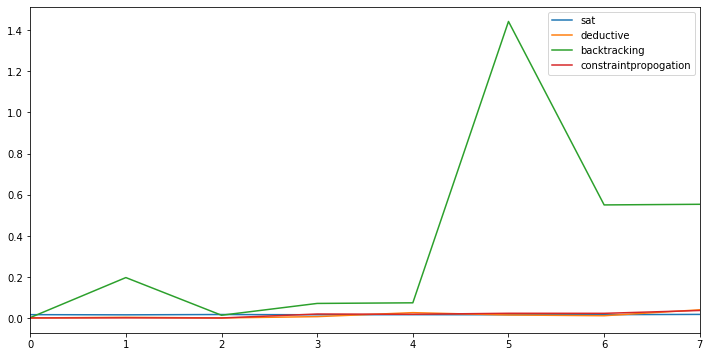

In [70]:
all_methods = list(pt.get_test_labels())
ax = df[all_methods].plot()
#ax.set_facecolor("#161716")

The scale of backtracking obscures the differences between the other methods. 

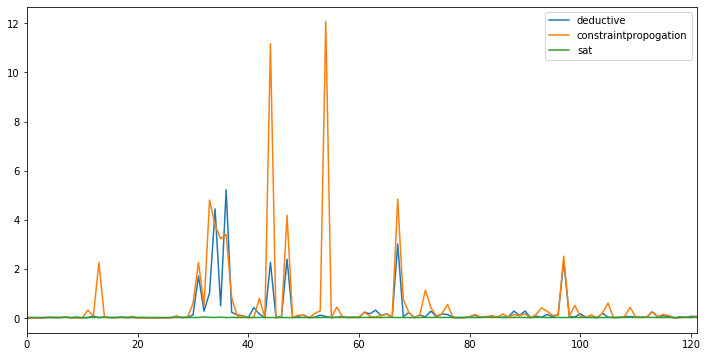

In [24]:
all_methods.remove('backtracking')
axs = df[all_methods].plot()

So this just seems to fit the same pattern, but because constraint propogation dramatically cuts the search space, the performance is generally faster. Those "spikes" are where a particular guess turns out to be *really bad* and there is a lot of backtracking to do.

You can also see the effect of the deductive solver. By solving a few cells straight away we cut the search space -- but there's still the occassional "bad guess" that triggers some backtracking.

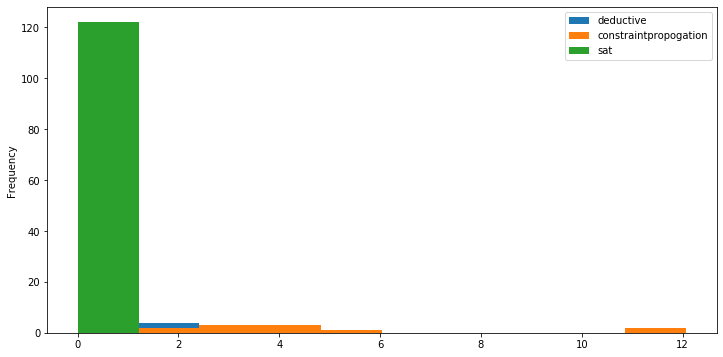

In [25]:
axs = df[all_methods].plot(kind='hist')

Meanwhile the performace of the SAT solver is consistently fast. I admit I don't fully understand the code, since I'm relying on [pycosat](https://pypi.org/project/pycosat/) and cribbing implementation details from [Taufan Ardhinata](https://github.com/taufanardi/sudoku-sat-solver). The conversion of a puzzle to a set of boolean clauses I eventually understood -- but the actual SAT solution algorithm is confusing me still.

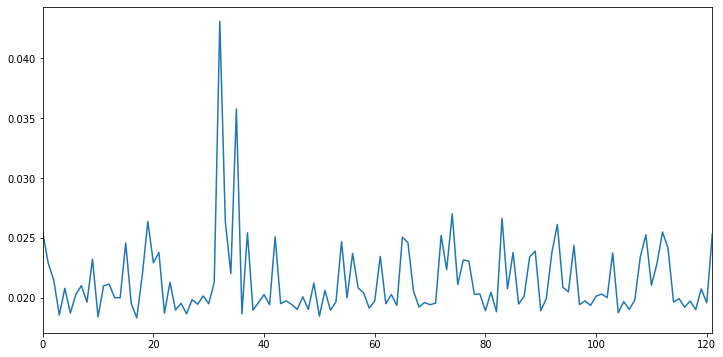

In [26]:
axs = df['sat'].plot()

So there is *some* variability in performance, just not a lot. At its heart SAT is a kind of backtracking algorithm I think, and `pycosat` is a wrapper around a C library so maybe that's why it's so much faster? 


---

# Diversions

Went down a few rabbit holes doing this...

## Diversion #1: Variability in performance on the *same* puzzle

Started looking at constrint propogation performance in more detail. The majority of the test puzzles are solved in < ~ 0.2 seconds, however there are some that take longer, up to a maxiumum of 12 seconds.

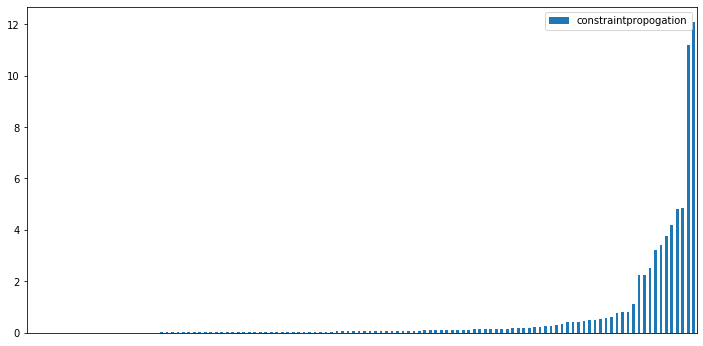

In [27]:
method = 'constraintpropogation'
axs = df.sort_values(by=method)[[method]].plot(kind='bar')
axs.xaxis.label.set_visible(False)
axs.xaxis.set_ticks([])
plt.show()

Let's take a look at those puzzles that take so much longer to solve and see if we can work out what's happening there.

In [28]:
def highlight_where_backtracking_faster(s):
    if s.constraintpropogation > s.backtracking:
        return ['background-color: yellow; color: black'] * len(s)
    else:
        return [''] * len(s)

method = 'constraintpropogation'
ndf = df.sort_values(by=method, ascending=False).head(n=15)
ndf.style.apply(highlight_where_backtracking_faster, axis=1).bar(subset=[method], color='orange').format({m: '{:.3f}' for m in su.SOLVERS})

,label,level,starting_clues,backtracking,constraintpropogation,deductive,sat
54,data/top95.txt:28,Diabolical,17,17.757,12.076,0.063,0.025
44,data/top95.txt:18,Diabolical,17,56.354,11.171,2.268,0.020
67,data/top95.txt:41,Diabolical,17,1173.908,4.840,3.015,0.021
33,data/top95.txt:7,Diabolical,17,1.697,4.804,1.025,0.026
47,data/top95.txt:21,Diabolical,17,43.075,4.180,2.395,0.020
34,data/top95.txt:8,Diabolical,17,113.328,3.775,4.442,0.022
36,data/top95.txt:10,Diabolical,17,108.590,3.400,5.219,0.019
35,data/top95.txt:9,Diabolical,17,1.691,3.226,0.491,0.036
97,data/top95.txt:71,Diabolical,17,205.605,2.515,2.329,0.019
31,data/top95.txt:5,Diabolical,17,790.428,2.263,1.707,0.021


Interesting points:

* Puzzles 7 and 9 (highlighted yellow) actually take longer to solve with the constraint propogation solution than simple backtracking
* Puzzles 21 and 46 look like good candidates for looking at closer, because the backtracking time isn't so long that we can't wait for profiler output if we want to compare profiles
* Puzzle 42 looks like a good place to start though: < ~1 second (highlighted green), deductive method on the same puzzle *much* faster, and backtracking time not so long tha we can't wait.

### Puzzle 42

So started looking at Puzzle 42 (answer to the Ultimate Question?), using the built in Jupyet profiler tools. First though, a quick check that the total time matches up. According to original testing performance, this should take ~8 microseconds (ms).


In [29]:
puzzle42 = '......8.16..2........7.5......6...2..1....3...8.......2......7..3..8....5...4....'
puzzle.init_puzzle(puzzle42)
solver = su.SudokuSolver(method=method)
%time solver.solve(puzzle)

CPU times: user 845 ms, sys: 9.35 ms, total: 854 ms
Wall time: 892 ms


True

That looks OK. So reset the puzzle and profile below. The profiler itself adds some overhead so this takes slightly longer (~1.2 seconds).

In [30]:
puzzle.init_puzzle(puzzle42)
s = su.SudokuSolver(method=method)
%prun s.solve(puzzle)

         2059323 function calls (2030333 primitive calls) in 1.274 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   398932    0.388    0.000    0.696    0.000 sudoku.py:101(get_allowed_values)
    57980    0.270    0.000    0.893    0.000 puzzlegrid.py:261(next_best_empty_cell)
   398932    0.199    0.000    0.199    0.000 puzzlegrid.py:298(get_allowed_values)
   456848    0.124    0.000    0.124    0.000 sudoku.py:53(box_xy_to_num)
  28991/1    0.084    0.000    1.274    1.274 sudoku.py:216(_solve_backtracking)
    28990    0.038    0.000    0.107    0.000 puzzlegrid.py:178(set)
    28926    0.035    0.000    0.079    0.000 sudoku.py:74(clear)
    28990    0.031    0.000    0.156    0.000 sudoku.py:61(set)
    28926    0.027    0.000    0.033    0.000 puzzlegrid.py:207(clear)
   341006    0.024    0.000    0.024    0.000 {built-in method builtins.len}
    86970    0.017    0.000    0.017    0.000 {method 'remove' of 'set

Notes:

* 399K calls to `get_allowed_values`. The first entry is in [sudoku.py](sudoku.py#line_88), which gets the allowed values for the box, then calls the same method in the [parent class](puzzlegrid.py#line_321) to return the intersection of allowed cells in that row, column and box.
* Recurses into `solve_constraintpropogation` 29K times.

Compare the performance of #42 to #46. Expect #46 to take ~2.5 seconds.

In [31]:
puzzle46 = '.834.........7..5...........4.1.8..........27...3.....2.6.5....5.....8........1..'
puzzle.init_puzzle(puzzle46)
solver = su.SudokuSolver(method=method)
%time solver.solve(puzzle)

CPU times: user 242 ms, sys: 2.51 ms, total: 244 ms
Wall time: 248 ms


True

OK, this is weird. That was supposed to take ~2.5 seconds and instead finished in ~0.3 seconds. Let's run it again...and again. And this time we'll output some of the stats collected by the solver itself:

* Max Depth: The deepest stack-depth the recursion reached
* Backtracks: The number of "mistakes" made by the algorithm that resulted in it backtracking to a prior state


In [32]:
method

'constraintpropogation'

In [33]:
puzzle = su.SudokuPuzzle()
solver = su.SudokuSolver(method=method)
for i in range(5):
    print(f"RUN {i}")
    puzzle.init_puzzle(starting_grid=puzzle46)
    assert(not puzzle.is_solved())
    %time solver.solve(puzzle)
    print(f"Max Depth={solver.solver.max_depth}; Backtracks={solver.solver.backtrack_count}\n")

RUN 0
CPU times: user 2.58 s, sys: 12 ms, total: 2.59 s
Wall time: 2.66 s
Max Depth=63; Backtracks=105917

RUN 1
CPU times: user 2.52 s, sys: 6.33 ms, total: 2.52 s
Wall time: 2.55 s
Max Depth=63; Backtracks=105917

RUN 2
CPU times: user 226 ms, sys: 593 µs, total: 227 ms
Wall time: 229 ms
Max Depth=63; Backtracks=8766

RUN 3
CPU times: user 236 ms, sys: 1.12 ms, total: 237 ms
Wall time: 241 ms
Max Depth=63; Backtracks=8766

RUN 4
CPU times: user 233 ms, sys: 1.05 ms, total: 234 ms
Wall time: 237 ms
Max Depth=63; Backtracks=8766



In testing, the first two usually take ~2.5 seconds, and the last 3 take ~220 ms. Even though it's exactly the same puzzle being solved by exactly the same algorithm.

It turns out the difference is caused by the return order of the set of allowed values. Since the values are returned in a set, the order of the elements is not guaranteed to be consistent. When the order is slightly different, then the backtracking can take dramatically different search paths, with consequent impacts on run time. You can see this in the `Backtracks` reported (~106K vs ~9K).

In this specific case, one of the cells has allowed values (1, 9). If "1" is chosen then the solution takes 2.5 seconds to find. However if the "9" is chosen, then the search takes ~220 ms. 

If I modify the algorithm to always sort the allowed values then the performance time is always consistent. Otherwise there's a certain amount of randmomness to it.

The other change is to recreate the `puzzle` instance each time. When I do that, the performance remains consistent, because the set order remains consistent. Not sure why that is.


## Diversion #2: Cheating

Occurred to me that the way I've designed the puzzle and solver classes opens the way to having a "cheating" solver. Basically a solver that over-writes the puzzle with a pre-programmed sequence of numbers that obey the rules but do not match the original puzzle clues.

So just for fun let's see how easy that is to do and how I could improve the puzzle class to detect and block attempts to "cheat".

### First attempt: Lie

First attempt was based on this code in the original implementation of `is_solved`:

```python
def is_solved(self):
    return self.is_puzzle_valid() and self._num_empty_cells == 0
```

So, how about a solver that just plain lies by over-writing the number of empty cells left?


In [34]:
class CheatingSolver(pg.ConstraintSolver):
    def solve(self, puzzle):
        """Easiest way to cheat would be to trick the is_solved() method on the puzzle to always returning True"""
        puzzle._num_empty_cells = 0
        return True

puzzle = su.SudokuPuzzle(starting_grid=su.SAMPLE_PUZZLES[0]['puzzle'])
solver = CheatingSolver()
solver.solve(puzzle)

True

So the solver will always return `True` but the puzzle itself should know that it's not really solved. I changed the `is_solved` method to actually check that every cell has a value.

```python
def is_solved(self):
    if self.is_puzzle_valid():
        for i in range(self.max_value()):
            for j in range(self.max_value()):
                if self.is_empty(i, j):
                    return False
        return True
    else:
        return False
```

In [35]:
puzzle.is_solved()

False

Now if we use this in the `PuzzleTester` then we want to make sure that it's detecting that the puzzle isn't really solved.

In [36]:
include_levels = ['Kids', 'Easy', 'Moderate', 'Hard']  # , 'Diabolical', 'Pathalogical']
test_cases = [x for x in su.SAMPLE_PUZZLES if x['level'] in include_levels]
pt = pg.PuzzleTester(puzzle_class=su.SudokuPuzzle)
pt.add_testcases(test_cases)

In [37]:
method = 'cheat'
solver = CheatingSolver()
pt.run_tests(solver, method)
df = pd.DataFrame(pt.get_test_results())
df.style.highlight_null()

,label,level,starting_clues,cheat
0,SMH 1,Kids,31,None
1,SMH 2,Easy,24,None
2,KTH 1,Easy,30,None
3,Rico Alan Heart,Easy,22,None
4,SMH 3,Moderate,26,None
5,SMH 4,Hard,22,None
6,SMH 5,Hard,25,None
7,Greg [2017],Hard,21,None


So I had to change `PuzzleTester` class to check the return value of the puzzle's `is_solved` method, rather than trust the solver's return value from `solve`. If the puzzle asserts that it is NOT solved then no result is recorded for the solver.

### Second attempt: Over-write with a canned solution

So since our really simple cheater no longer works I guess we'll need a more sophisticated version. We could just fill in the blank cells with "1" (or any other value) but then the `is_puzzle_valid` check would fail, at which point we may as well solve it properly. 


So maybe what our cheat needs to do is overwrite *all* cells in a rule-abiding way. We won't be actually solving the original puzzle. Basically, we're just writing a "pre-solved" puzzle over the top.


In [38]:
class CheatingSolver(pg.ConstraintSolver):
    def solve(self, puzzle):
        """Write a pre-solved puzzle in over the top of the provided one"""
        starting_values = [0, 3, 6, 1, 4, 7, 2, 5, 8]
        max_value = puzzle.max_value()
        assert max_value == 9, "I can't handle puzzles other than 9x9"
        puzzle.clear_all()
        for i in range(max_value):
            for j in range(max_value):
                #print(i, j, (starting_values[i] + j) % max_value + 1)
                puzzle.set(i, j, (starting_values[i] + j) % max_value + 1)
        return True

In [39]:
puzzle = su.SudokuPuzzle(starting_grid=su.SAMPLE_PUZZLES[0]['puzzle'])
solver = CheatingSolver()
solver.solve(puzzle)
puzzle.is_solved()

True

So the cheat works. 

Now, the whole point of cheating here is to be faster than a real solver, so let's test performance.


In [40]:
for m in su.SOLVERS:
    solver = su.SudokuSolver(method=m)
    pt.run_tests(solver, m)

In [41]:
method = 'cheat'
all_methods = list(pt.get_test_labels())
all_methods.append(method)

solver = CheatingSolver()
pt.run_tests(solver, method)
show_results(pt, axis=1)

,label,level,starting_clues,cheat,backtracking,constraintpropogation,deductive,sat
0,SMH 1,Kids,31,0.001,0.003,0.002,0.002,0.017
1,SMH 2,Easy,24,0.001,0.198,0.002,0.005,0.017
2,KTH 1,Easy,30,0.001,0.015,0.001,0.001,0.018
3,Rico Alan Heart,Easy,22,0.001,0.072,0.021,0.008,0.017
4,SMH 3,Moderate,26,0.001,0.075,0.019,0.027,0.017
5,SMH 4,Hard,22,0.001,1.442,0.024,0.016,0.017
6,SMH 5,Hard,25,0.001,0.551,0.024,0.012,0.017
7,Greg [2017],Hard,21,0.001,0.554,0.038,0.041,0.019


## Diversion #3: Catching Cheats

To prevent the new cheat we basically need to compare the puzzle with a copy of the original. That way we can detect that the starting clues have been over written.

We can't do this in the `SudokuPuzzle` itself. Python doesn't really have `private` attributes, [more a naming convention](https://docs.python.org/3/tutorial/classes.html#tut-private) that signals "hey, you're not supposed to muck around with this", but we've already seen that we can pretty much ignore that and modify the class's internals. And since we're trying to guard against cheating we can assume an attacker will happily ignore convention.

If we assume that the caller (test harness) can be trusted then we can let the caller verify that the original puzzle is OK. We'll just need a function that confirms if the starting clues in one puzzle also exist in the second.


In [42]:
def has_same_clues(a, b):
    """Returns true if the non empty cells in a have the same value in b"""
    if a.max_value() != b.max_value():
        return False
    
    for i in range(a.max_value()):
        for j in range(a.max_value()):
            if not a.is_empty(i, j) and a.get(i, j) != b.get(i, j):
                return False
    return True

In [43]:
puzzle = su.SudokuPuzzle(starting_grid=su.SAMPLE_PUZZLES[-1]['puzzle'])
original = copy.deepcopy(puzzle)
has_same_clues(original, puzzle)

True

In [44]:
solver.solve(puzzle)
puzzle.is_solved()

True

In [45]:
has_same_clues(original, puzzle)

False

Putting it all together, let's ~~monkey patch~~ switch on anti-cheat checking and make sure it throws away test results if the solver has cheated.

In [71]:
pt.anti_cheat_checking = True
pt.run_tests(solver, method)
df = pd.DataFrame(pt.get_test_results())
df.style.highlight_null()

,label,level,starting_clues,cheat,backtracking,constraintpropogation,deductive,sat
0,SMH 1,Kids,31,None,0.00305,0.00152,0.00153,0.0175
1,SMH 2,Easy,24,None,0.198,0.00189,0.00458,0.0166
2,KTH 1,Easy,30,None,0.0147,0.00135,0.00148,0.0181
3,Rico Alan Heart,Easy,22,None,0.072,0.0206,0.00785,0.017
4,SMH 3,Moderate,26,None,0.075,0.0194,0.0272,0.0174
5,SMH 4,Hard,22,None,1.44,0.0242,0.0159,0.017
6,SMH 5,Hard,25,None,0.551,0.0239,0.0123,0.0175
7,Greg [2017],Hard,21,None,0.554,0.0378,0.0411,0.0187


OK! Our cheating solver has had no results recorded for it, because the answer it gives does not match the starting clues!

There are probably ways to defeat these checks, particularly in a language like Python where "monkey patching" is a thing and everything is dynamic. That might be a fun way to learn more about the internals of Python, but for now I'm declaring this "done" and moving on to the next puzzle...

---
# Conclusion

*TODO:* Next steps?


In [51]:
import datetime
print(datetime.datetime.now())

2020-09-11 21:18:05.641775


---
# Appendix

## Sources

Part of this exercise was to learn Python and Jupyter skills while also solving a problem that I found interesting. So I've largely avoided reading other people's solutions to solving Sudoku. However from time to time I've gotten stuck or just been curious about something and found the below sources useful.

* The "Top 95" and "Hardest" puzzle examples in the data directory come from [Solving Every Sudoku Puzzle (by Peter Norvig)](https://norvig.com/sudoku.html)
* [Sudoku solving algorithms](https://en.wikipedia.org/wiki/Sudoku_solving_algorithms) -- links to some sample puzzles (on Flickr of all places). Found via the [Wikipedia article on Sudoku solving algorithms](https://en.wikipedia.org/wiki/Sudoku_solving_algorithms).
* [AI Sudoku](http://www.aisudoku.com/index_en.html) -- collection of really hard puzzles.
* The [sudoku.py](sudoku.py) class has URLs to where I found some of the sample puzzles. I've attempted to use labels for them that credit the source, although it's not always clear where the original puzzle came from.
* Also used examples from [Simple sudoku solver using constraint propagation](https://gpicavet.github.io/jekyll/update/2017/12/16/sudoku-solver.html) (Grégory Picavet's Blog).


## Table formatting

Snippet below inserts some CSS to make the table look more like a Sudoku puzzle grid.


In [54]:
display(HTML('''
<style type="text/css">
.sudoku table {
    border: 3px solid red;
    text-align: center; 
    vertical-align: middle;
}

.sudoku td {
    width: 40px;
    height: 40px;
    border: 1px solid #F00;
}

.sudoku td:nth-of-type(3n) {    
    border-right: 3px solid red;
}

.sudoku tr:nth-of-type(3n) td {    
    border-bottom: 3px solid red;
}

.sudoku.solved table {
    border: 3px solid green;
}

.sudoku.solved td {
    border: 1px solid green;
}

.sudoku.solved td:nth-of-type(3n) {    
    border-right: 3px solid green;
}

.sudoku.solved tr:nth-of-type(3n) td {    
    border-bottom: 3px solid green;
}

</style>
'''))

Scratch.txt

#10: Rico Alan Border #1
Greg: Solved in 3 ms, 59 tests, 0 backtracks
Me: Solved in 3 ms

#13: Rico Alan #3
Greg: Invalid board!
Me: Solved in 1.771 s

#11: Rico Alan #4
Greg: Solved in 30 ms, 5396 tests, 2371 backtracks
Me: Solved in 26 ms

#12: Qassim Hamza
Greg: Solved in 15 ms
Me: Solved in 59 ms

#14: World's Hardest Sudoku 2012
Greg: Solved in 21 ms
Me: Solved in 30 ms

#15: AI escargot
Greg: Solved in 1 ms, 187 tests, 12 backtracks
Me: Solved in 4 ms